In [54]:
import torch
from PIL import Image
import mobileclip
import os
import numpy as np
from pathlib import Path
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [55]:
# initiate the mobileclip model and test running.
model, _, preprocess = mobileclip.create_model_and_transforms('mobileclip_s0', pretrained='C:\\Users\\quinnfu\\QF_Clip\\checkpoints\\mobileclip_s0.pt')
tokenizer = mobileclip.get_tokenizer('mobileclip_s0')
image = preprocess(Image.open("C:\\Users\\quinnfu\\QF_Clip\\images\\test.jpg").convert('RGB')).unsqueeze(0)
text = tokenizer(["dinner", "soup", "a cat"])

with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)

Label probs: tensor([[9.0729e-01, 9.2699e-02, 1.0240e-05]])


In [56]:
class ImageLibrary:
    def __init__(self):
        self.image_paths = []
        self.image_features = []
        self.index = None
        
    def add_image(self, image_path, feature_vector):
        self.image_paths.append(image_path)
        self.image_features.append(feature_vector)

    def build_index(self):
        features = np.array(self.image_features)
        d = features.shape[1]  # 向量维度
        self.index = faiss.IndexFlatIP(d)  # 使用内积相似度
        self.index.add(features)

    def search(self, query_vector, k=3):
        if self.index is None:
            self.build_index()
        scores, indices = self.index.search(query_vector.reshape(1, -1), k)
        return [(self.image_paths[idx], score) for score, idx in zip(scores[0], indices[0])]

# 创建图片库实例
image_library = ImageLibrary()

# 配置图片库目录
IMAGE_LIBRARY_DIR = 'C:\\Users\\quinnfu\\QF_Clip\\images'

In [57]:

def process_image(image):
    """处理图片并返回特征向量"""
    img_tensor = preprocess(image.convert('RGB')).unsqueeze(0)
    with torch.no_grad():
        features = model.encode_image(img_tensor)
        features = features / features.norm(dim=-1, keepdim=True)
    return features.cpu().numpy()[0]

def process_text(text):
    """处理文本并返回特征向量"""
    text_token = tokenizer([text])
    with torch.no_grad():
        features = model.encode_text(text_token)
        features = features / features.norm(dim=-1, keepdim=True)
    return features.cpu().numpy()[0]

def build_image_library():
    """构建图片库"""
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        for img_path in Path(IMAGE_LIBRARY_DIR).glob(ext):
            try:
                image = Image.open(img_path)
                features = process_image(image)
                # 存储完整路径以便后续访问
                image_library.add_image(str(img_path), features)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    image_library.build_index()
    print("Image library built successfully!")

In [58]:
def plot_results(results, query=None, is_text_query=True):
    """显示检索结果"""
    n = len(results)
    fig = plt.figure(figsize=(15, 3))
    
    if is_text_query:
        fig.suptitle(f'Query text: {query}')
    else:
        fig.suptitle('Query image and results')
        # 显示查询图片
        plt.subplot(1, n+1, 1)
        plt.imshow(Image.open(query))
        plt.title('Query')
        plt.axis('off')
    
    # 显示结果图片
    for i, (path, score) in enumerate(results):
        plt.subplot(1, n+1, i+2 if not is_text_query else i+1)
        plt.imshow(Image.open(path))
        plt.title(f'Score: {score:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Image library built successfully!


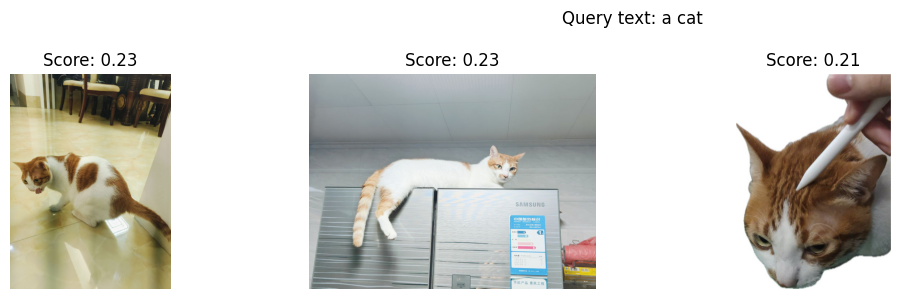

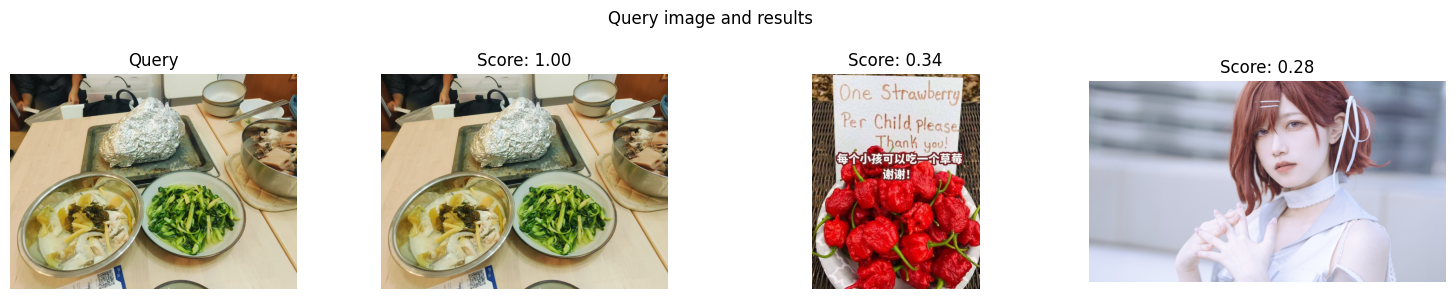

In [59]:
# 构建图片库
build_image_library()

# 使用文本进行检索
query_text = "a cat"
text_features = process_text(query_text)
results = image_library.search(text_features)
plot_results(results, query_text)

# 使用图片进行检索
query_image_path = "C:\\Users\\quinnfu\\QF_Clip\\images\\test.jpg"
query_image = Image.open(query_image_path)
image_features = process_image(query_image)
results = image_library.search(image_features)
plot_results(results, query_image_path, is_text_query=False)